<center>
    <h1>An Investigation of EPA Air Quality Data from 2000 - 2017</h1>
    <h2>Created by Team VAS</h2>
</center>

<h3> Notebook Sections: </h3>
<ul>
    <li><b>Environment Setup</b></li>
    <li><b>Chart 1: </b><a href="#one">Choropleth Map</a></li>
    <li><b>Chart 2: </b><a href="#two">Scatter Plot Map</a></li>
    <li><b>Chart 3: </b><a href="#three">Boxplot Graph</a></li>
    <li><b>Chart 4: </b><a href="#four">Stacked Bar Graph</a></li>
    <li><b>Chart 5: </b><a href="#five">Vertical Bar Graph</a></li>
</ul>
    
<h4>The dataset used can be accessed
    <a href="https://www.kaggle.com/epa/epa-historical-air-quality">here</a>
</h4>

<hr>
<center>
    <h1> Environment Setup </h1>
</center>


<div class="alert alert-block alert-danger">
    <b>Prequisite:</b> <br>
    
     You must have installed BigQuery:
    <br>
    <li>pip install --upgrade google-cloud-bigquery[bqstorage,pandas]</li>
     and give the session Google Credentials by using the DataViz.json file:
    <li>       export GOOGLE_APPLICATION_CREDENTIALS="{%PATH%}/Data-Viz.json" </li>
</div>

### Load Google Big Query to the data using magics 

In [3]:
%load_ext google.cloud.bigquery

### Load Neccessary Packages for Graphing

In [4]:
#inline flag for figure display in notebook
%matplotlib inline
%matplotlib nbagg

#load packages into the environment
import cufflinks as cf
import numpy as np #linear algebra
import pandas as pd #data processing & handling
cf.go_offline()

#load matplotlib for plotting
import seaborn as sns #matplotlib wrapper
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon
import shapefile
from decimal import *
import nbconvert

#load plotly
from plotly.offline import download_plotlyjs, plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
from plotly import tools
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.figure_factory as fig_fact

#load mapping dependencies
import folium
from folium.plugins import MarkerCluster
import branca

# normalize datasets
from sklearn import preprocessing


<div id = "one">
    <hr>
<center>
    <h1> Chart 1: Choropleth Map </h1>
<br>
<b>Purpose:</b> The goal of this map is to provide a general overview of the air pollution concentration across the United States.
</center>  
</div>
</div>

### Load variables from CSV

In [ ]:
df = pd.read_csv(r'/Users/vaustin/epa_air_quality_annual_summary.csv', low_memory=False)

### Clean and Process the Data

In [ ]:
#Data pre-processing and clean up
df['pollutant_standard'].fillna('UNKNOWN',inplace=True)
df['parameter_name'].fillna('UNKNOWN',inplace=True)
df['city_name'].fillna('UNKNOWN',inplace=True)
df['county_name'].fillna('UNKNOWN',inplace=True)
df= df[df['parameter_name'] != 'Elapsed Sample Time']
df= df[df['parameter_name'] != 'Ambient Max Temperature']
df= df[df['parameter_name'] != 'Average Ambient Pressure']
df= df[df['parameter_name'] != 'Wind Direction - Scalar']
df= df[df['parameter_name'] != 'Relative Humidity']
df= df[df['parameter_name'] != 'Sample Volume']
df= df[df['parameter_name'] != 'Particle Number Total Count']
df= df[df['parameter_name'] != df.parameter_name.str.contains('Sample',na=False) ]

#Outliers where the percentile data was above 10k
df[ df['seventy_five_percentile'] == df['seventy_five_percentile'].max() ] #1 record
df[ (df['seventy_five_percentile'] >= 10000.0) &  (df['seventy_five_percentile'] <= 20000.0 )] # 78 records

#  1980s - Hydro carbon California state only
df.groupby(['state_name','year','parameter_name']).agg({'seventy_five_percentile':'count'})
df[ (df['seventy_five_percentile'] >= 5000.0) &  (df['seventy_five_percentile'] <= 10000.0 )] # 47 records
df1= df[ (df['seventy_five_percentile'] <= 90.0) & (df['seventy_five_percentile'] >= 0.6) ]

### Normalize the Dataframe

In [ ]:
# Load data frame and tidy it.

# Create x, where x the 'scores' column's values as floats
x = df1[['seventy_five_percentile']].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(x_scaled)

df1['seventy_five_percentile']= df_normalized

### Plot the Dataframe using Plotly

In [ ]:
# plotly does not take state names rather codes, can use fif codes with county
state_codes = {
    'District of Columbia' : 'DC','Mississippi': 'MS', 'Oklahoma': 'OK',
    'Delaware': 'DE', 'Minnesota': 'MN', 'Illinois': 'IL', 'Arkansas': 'AR',
    'New Mexico': 'NM', 'Indiana': 'IN', 'Maryland': 'MD', 'Louisiana': 'LA',
    'Idaho': 'ID', 'Wyoming': 'WY', 'Tennessee': 'TN', 'Arizona': 'AZ',
    'Iowa': 'IA', 'Michigan': 'MI', 'Kansas': 'KS', 'Utah': 'UT',
    'Virginia': 'VA', 'Oregon': 'OR', 'Connecticut': 'CT', 'Montana': 'MT',
    'California': 'CA', 'Massachusetts': 'MA', 'West Virginia': 'WV',
    'South Carolina': 'SC', 'New Hampshire': 'NH', 'Wisconsin': 'WI',
    'Vermont': 'VT', 'Georgia': 'GA', 'North Dakota': 'ND',
    'Pennsylvania': 'PA', 'Florida': 'FL', 'Alaska': 'AK', 'Kentucky': 'KY',
    'Hawaii': 'HI', 'Nebraska': 'NE', 'Missouri': 'MO', 'Ohio': 'OH',
    'Alabama': 'AL', 'Rhode Island': 'RI', 'South Dakota': 'SD',
    'Colorado': 'CO', 'New Jersey': 'NJ', 'Washington': 'WA',
    'North Carolina': 'NC', 'New York': 'NY', 'Texas': 'TX',
    'Nevada': 'NV', 'Maine': 'ME'}

data=dict(type='choropleth',
         locations=list(state_codes.values()),
         locationmode='USA-states',
         colorscale='Portland',
         text="Pollutant: " + df2['parameter_name'] + '<br>' + "Year: " + df2['year'].apply(str) + \
               '<br>' + "units_of_measure: " + df2['units_of_measure'].apply(str) ,
         z = df2['seventy_five_percentile'],
         colorbar={'title':'Pollutant Concentration Index'})

layout = dict(title_text='US Air Pollution Concentration (Hover for breakdown)', geo={'scope':'usa'})

choromap = go.Figure(data=[data], layout=layout)

iplot(choromap)
#plot(choromap, filename='graph.html')

Since the graph and csv files are so large, they can be downloaded individually here:

<b>CSV:</b> https://www.filehosting.org/file/details/836731/epa_air_quality_annual_summary.csv
<br>
<b>Map:</b> https://www.filehosting.org/file/details/836746/graph.html

<div id = "two">
    <hr>
<center> 
    <h1> Chart 2: Scatter Plot Map </h1>
<br>
<b>Purpose:</b> The goal of this map is to display the location of each measurement site in New York as well as the highest measured average air quality index. 
</center>  
</div>

### Call variables using SQL and BigQuery 

In [5]:
%%bigquery ttl
SELECT *
FROM (
(select latitude, longitude, EXTRACT(YEAR FROM date_local) as day_of_year, avg(aqi) as avg_aqi, parameter_name
  from `bigquery-public-data.epa_historical_air_quality.co_daily_summary` as co 
  where aqi is not null and poc=1 and EXTRACT(YEAR FROM date_local)>1999 and state_name="New York"
  group by latitude, longitude, day_of_year, parameter_name
  order by day_of_year asc) 
  UNION ALL
  (select latitude, longitude, EXTRACT(YEAR FROM date_local) as day_of_year, avg(aqi) as avg_aqi, parameter_name 
  from `bigquery-public-data.epa_historical_air_quality.no2_daily_summary` as no2
  where aqi is not null and poc=1 and EXTRACT(YEAR FROM date_local)>1999 and state_name="New York"
  group by latitude, longitude, day_of_year, parameter_name
  order by day_of_year asc)
  UNION ALL
  (select latitude, longitude, EXTRACT(YEAR FROM date_local) as day_of_year, avg(aqi) as avg_aqi, parameter_name 
  from `bigquery-public-data.epa_historical_air_quality.so2_daily_summary` as so2
  where aqi is not null and poc=1 and EXTRACT(YEAR FROM date_local)>1999 and state_name="New York" 
  group by latitude, longitude, day_of_year, parameter_name
  order by day_of_year asc) 
  UNION ALL
  (select latitude, longitude, EXTRACT(YEAR FROM date_local) as day_of_year, avg(aqi) as avg_aqi, parameter_name  
  from `bigquery-public-data.epa_historical_air_quality.o3_daily_summary` as o3
  where aqi is not null and poc=1 and EXTRACT(YEAR FROM date_local)>1999 and state_name="New York" 
  group by latitude, longitude, day_of_year, parameter_name
  order by day_of_year asc)
  UNION ALL
  (select latitude, longitude, EXTRACT(YEAR FROM date_local) as day_of_year, avg(aqi) as avg_aqi, parameter_name 
  from `bigquery-public-data.epa_historical_air_quality.pm25_frm_daily_summary` as pm25
  where aqi is not null and poc=1 and EXTRACT(YEAR FROM date_local)>1999 and state_name="New York" 
  group by latitude, longitude, day_of_year, parameter_name
  order by day_of_year asc))t

### Create Map Marker Table

In [6]:
def fancy_html(row):
    
    Lat = row['latitude']
    AQI = row['avg_aqi']
    POL = row['parameter_name']
    
    left_col_colour = "#2A799C"
    right_col_colour = "#C5DCE7"
    
    getcontext().prec=4
    
    html = """<!DOCTYPE html>
<html>

<table style="height: 126px; width: 300px;">
<tbody>
<tr>
<td style="background-color: """+ left_col_colour +""";"><span style="color: #ffffff;"><center>Latitude</center></span></td>
<td style="width: 150px;background-color: """+ right_col_colour +""";"> &nbsp; &nbsp; {0:.4f}</td>""".format(round(la['latitude'],5)) + """
</tr>
<tr>
<td style="background-color: """+ left_col_colour +""";"><span style="color: #ffffff;"><center>Longitude</center></span></td>
<td style="width: 150px;background-color: """+ right_col_colour +""";"> &nbsp; &nbsp; {0:.4f}</td>""".format(round(la['longitude'],5)) + """
</tr>
<tr>
<td style="background-color: """+ left_col_colour +""";"><span style="color: #ffffff;"><center>Highest Avg AQI</center></span></td>
<td style="width: 150px;background-color: """+ right_col_colour +""";"> &nbsp; &nbsp; {0:.4f}</td>""".format(AQI) + """
</tr>
<tr>
<td style="background-color: """+ left_col_colour +""";"><span style="color: #ffffff;"><center>Pollutant Name</center></span></td>
<td style="width: 150px;background-color: """+ right_col_colour +""";"> &nbsp; &nbsp; {}</td>""".format(POL) + """
</tr>
</tbody>
</table>
</html>
"""
    return html

### Build Map Graph using Folium

In [8]:
icon_create_function = """
function(cluster) {
    return L.divIcon({
    html: '&nbsp <span style="font-size:15px">' + cluster.getChildCount() + '</span>',
    className: 'marker-cluster marker-cluster-large',
    iconSize: new L.Point(30, 30)
    });
}"""

df_2000 = pd.DataFrame(ttl[ttl['day_of_year']==2000]) 

mLoc = folium.Map(location=[42.930610, -75.935242], zoom_start=6.5) 

m = folium.FeatureGroup()

tooltip = 'Click me <br> for more!'

cluster = MarkerCluster(
    name='cluster icons',
    overlay=True,
    control=True,
    icon_create_function=icon_create_function
)

for f, la in df_2000.iterrows():
    html = fancy_html(la)
    iframe = branca.element.IFrame(html=html,width=300,height=150)
    popup = folium.Popup(iframe,parse_html=True)
    clr = ''
    if la['avg_aqi'] < 50:
        clr = 'green'
    elif la['avg_aqi'] > 50 and la['avg_aqi'] < 100:
        clr = 'orange'
    else:
        clr = 'red'
    
    location = la['latitude'], la['longitude']
    marker = folium.Marker(location=location, popup=popup, tooltip=tooltip,
    icon=folium.Icon(icon='info-sign', color=clr))
    cluster.add_child(marker)
    

m.add_child(cluster)

mLoc.add_child(m)

legend_html = '''
    <div style="position: fixed; background: white; 
    bottom: 30px; left: 50px; width: 120px; height: 120px; 
    border:2px solid grey; z-index:9999; font-size:14px;">
    &nbsp; Marker Legend 
    <br>
    &nbsp; Good &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;<i class="fa fa-map-marker fa-2x" style="color:green"></i>
    <br>
    &nbsp; Moderate &nbsp;&nbsp; <i class="fa fa-map-marker fa-2x" style="color:orange"></i>
    <br>
    &nbsp; Unhealthy &nbsp; <i class="fa fa-map-marker fa-2x" style="color:red"></i>
    </div>
    ''' 

mLoc.get_root().html.add_child(folium.Element(legend_html))
mLoc

<div id = "three">
    <hr>
<center>
    <h1> Chart 3: Boxplot Graph   </h1>
<br>
<b>Purpose:</b> The goal of this graph is to understand the annual distribution of each pollutant. 
</center>    
</div>

### Call variables using SQL and BigQuery 

#### Find Annual AQI of Nitrogen Dioxide

In [7]:
%%bigquery bx1
SELECT
        EXTRACT(YEAR FROM date_local) as day_of_year,
        aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.so2_daily_summary`
    WHERE
      aqi is not null and poc = 1 and state_name="New York" and EXTRACT(YEAR FROM date_local) > 1999
    GROUP BY
        day_of_year, aqi
    ORDER BY
        day_of_year

#### Find Annual AQI of Carbon Monoxide

In [8]:
%%bigquery bx2
SELECT
        EXTRACT(YEAR FROM date_local) as day_of_year,
        aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.co_daily_summary`
    WHERE
      aqi is not null and poc = 1 and state_name="New York" and EXTRACT(YEAR FROM date_local) > 1999
    GROUP BY
        day_of_year, aqi
    ORDER BY
        day_of_year

#### Find Annual AQI of Nitrogen Dioxide

In [9]:
%%bigquery bx3
SELECT
        EXTRACT(YEAR FROM date_local) as day_of_year,
        aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.no2_daily_summary`
    WHERE
      aqi is not null and poc = 1 and state_name="New York" and EXTRACT(YEAR FROM date_local) > 1999
    GROUP BY
        day_of_year, aqi
    ORDER BY
        day_of_year

#### Find Annual AQI of Ozone

In [10]:
%%bigquery bx4
SELECT
        EXTRACT(YEAR FROM date_local) as day_of_year,
        aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.o3_daily_summary`
    WHERE
      aqi is not null and poc = 1 and state_name="New York" and EXTRACT(YEAR FROM date_local) > 1999
    GROUP BY
        day_of_year, aqi
    ORDER BY
        day_of_year

#### Find Annual AQI of Particulate Matter 2.5

In [11]:
%%bigquery bx5
SELECT
        EXTRACT(YEAR FROM date_local) as day_of_year,
        aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.pm25_frm_daily_summary`
    WHERE
        aqi is not null and poc = 1 and state_name="New York" and EXTRACT(YEAR FROM date_local) > 1999
    GROUP BY
        day_of_year, aqi
    ORDER BY
        day_of_year

### Plot the Dataframes using Matplotlib

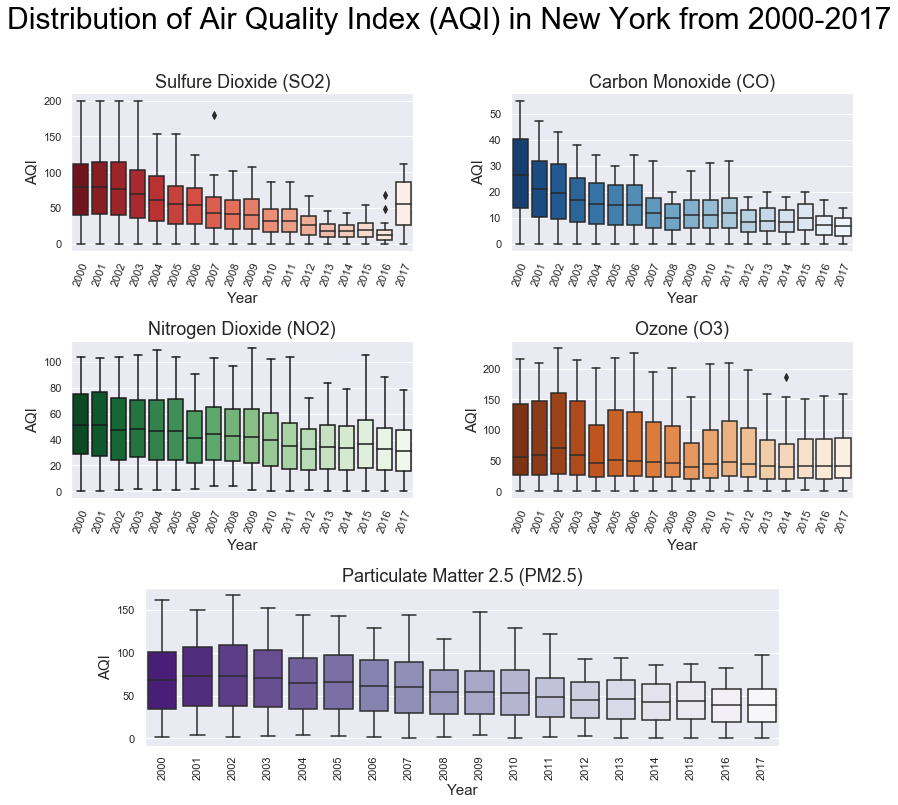

In [12]:
fig, axs = plt.subplots(3,2, figsize=(14, 12),squeeze=False)
fig.suptitle('Distribution of Air Quality Index (AQI) in New York from 2000-2017',fontsize=30)
sns.set(style="darkgrid")
gs = gridspec.GridSpec(11,11)

ax1 = plt.subplot(gs[0:3, 0:5])
ax1.set_title('Sulfure Dioxide (SO2)', fontsize=18)
sns.boxplot(x='day_of_year',y='aqi', data=bx1, ax=ax1, palette="Reds_r")
ax1.set_ylabel('AQI', fontsize=15)
ax1.set_xlabel('Year', fontsize=15)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=70)

ax2 = plt.subplot(gs[0:3, 6:])
ax2.set_title('Carbon Monoxide (CO)', fontsize=18)
sns.boxplot(x='day_of_year',y='aqi', data=bx2, ax=ax2,palette="Blues_r")
ax2.set_ylabel('AQI', fontsize=15)
ax2.set_xlabel('Year', fontsize=15)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=70)

ax3 = plt.subplot(gs[4:7, 0:5])
ax3.set_title('Nitrogen Dioxide (NO2)', fontsize=18)
sns.boxplot(x='day_of_year',y='aqi', data=bx3, ax=ax3,palette="Greens_r")
ax3.set_ylabel('AQI', fontsize=15)
ax3.set_xlabel('Year', fontsize=15)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=70)

ax4 = plt.subplot(gs[4:7, 6:])
ax4.set_title('Ozone (O3)', fontsize=18)
sns.boxplot(x='day_of_year',y='aqi', data=bx4, ax=ax4,palette="Oranges_r")
ax4.set_ylabel('AQI', fontsize=15)
ax4.set_xlabel('Year', fontsize=15)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=70)

ax5 = plt.subplot(gs[8:, 1:10])
ax5.set_title('Particulate Matter 2.5 (PM2.5)', fontsize=18)
sns.boxplot(x='day_of_year',y='aqi', data=bx5, ax=ax5,palette="Purples_r")
ax5.set_ylabel('AQI', fontsize=15)
ax5.set_xlabel('Year', fontsize=15)
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=90)


plt.subplots_adjust(wspace=0.5, hspace=0.8)
plt.show()

<div id = "four">
    <hr>
<center>
    <h1> Chart 4: Stacked Bar Graph </h1>
<br>
<b>Purpose: </b> The goal of this graph is to visualize the total average air quality index by year by pollutant.
</center>    
</div>

### Call variables using SQL and BigQuery  

#### Find Annual Avg. AQI of Nitrogen Dioxide  

In [13]:
%%bigquery var1
SELECT
        EXTRACT(YEAR FROM date_local) as day_of_year,
        avg(aqi) as avg_aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.no2_daily_summary`
    WHERE
      aqi is not null and poc = 1 and state_name="New York" and EXTRACT(YEAR FROM date_local) > 1999
    GROUP BY day_of_year
    ORDER BY day_of_year ASC

#### Find Annual Avg. AQI of Carbon Monoxide

In [14]:
%%bigquery var2
SELECT
        EXTRACT(YEAR FROM date_local) as day_of_year,
        avg(aqi) as avg_aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.co_daily_summary`
    WHERE
      aqi is not null and poc = 1 and state_name="New York" and EXTRACT(YEAR FROM date_local) > 1999
    GROUP BY day_of_year
    ORDER BY day_of_year ASC

#### Find Annual Avg. AQI of Particulate Matter 2.5  

In [15]:
%%bigquery var4
SELECT
        EXTRACT(YEAR FROM date_local) as day_of_year,
        avg(aqi) as avg_aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.pm25_frm_daily_summary`
    WHERE
      aqi is not null and poc = 1 and state_name="New York" and EXTRACT(YEAR FROM date_local) > 1999
    GROUP BY day_of_year
    ORDER BY day_of_year ASC

#### Find Annual Avg. AQI of Sulphur Dioxide  

In [16]:
%%bigquery var5
SELECT
        EXTRACT(YEAR FROM date_local) as day_of_year,
        avg(aqi) as avg_aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.so2_daily_summary`
    WHERE
      aqi is not null and poc = 1 and state_name="New York" and EXTRACT(YEAR FROM date_local) > 1999
    GROUP BY day_of_year
    ORDER BY day_of_year ASC

#### Find Annual Avg. AQI of Ozone  

In [17]:
%%bigquery var6
SELECT
        EXTRACT(YEAR FROM date_local) as day_of_year,
        avg(aqi) as avg_aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.o3_daily_summary`
    WHERE
      aqi is not null and poc = 1 and state_name="New York" and EXTRACT(YEAR FROM date_local) > 1999
    GROUP BY day_of_year
    ORDER BY day_of_year ASC

### Plot the Dataframes using Plotly 

In [18]:
fig = go.Figure()

fig.add_trace(go.Bar(
    y=var5['day_of_year'],
    x=var5['avg_aqi'],
    name='Sulfur Dioxide (SO2)',
    orientation='h',
    marker=dict(
        color='rgba(255,0,0,0.6)',
        line=dict(color='rgba(246, 78, 139, 1.0)', width=2)
    )
))
fig.add_trace(go.Bar(
    y=var1['day_of_year'],
    x=var1['avg_aqi'],
    name='Nitrogen Dioxide (NO2)',
    orientation='h',
    marker=dict(
        color='rgba(41, 241, 195, 0.6)',
        line=dict(color='rgba(58, 71, 80, 0.6)', width=2)
    )
))
fig.add_trace(go.Bar(
    y=var4['day_of_year'],
    x=var4['avg_aqi'],
    name='Particulate Matter 2.5 (PM2.5)',
    orientation='h',
    marker=dict(
        color='rgba(107, 67, 120,1)',
        line=dict(color='rgba(58, 71, 80, 0.6)', width=2)
    )
))
fig.add_trace(go.Bar(
    y=var6['day_of_year'],
    x=var6['avg_aqi'],
    name='Ozone (O3)',
    orientation='h',
    marker=dict(
        color='rgba(255,165,0,0.6)',
        line=dict(color='rgba(58, 71, 80, 1.0)', width=2)
    )
))
fig.add_trace(go.Bar(
    y=var2['day_of_year'],
    x=var2['avg_aqi'],
    name='Carbon Monoxide (CO)',
    orientation='h',
    marker=dict(
        color='rgba(0,0,255,0.6)',
        line=dict(color='rgba(58, 71, 80, 1.0)', width=2)
    )
))

fig.update_layout(barmode='stack', 
                  title='&nbsp; &nbsp; &nbsp; &nbsp; Average Air Quality Index (AQI) in New York from 2000-2017 (Hover for Breakdown)', 
                  xaxis_title='Total Avg. AQI', 
                  yaxis_title='Year')
fig.show()

<div id = "five">
    <hr>
<center>
    <h1> Chart 5: Vertical Bar Graph    </h1>
<br>
<b>Purpose: </b> The goal of this graph is to show the annual level of pollutants broken down by New York counties.
</center>    
</div>

### Call variables using SQL and BigQuery 

#### Find Annual Avg. AQI of Nitrogen Dioxide by County

In [19]:
%%bigquery bar1
SELECT
        county_name,
        avg(aqi) as avg_aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.no2_daily_summary`
    WHERE
      aqi is not null and poc = 1 and state_name="New York" and EXTRACT(YEAR FROM date_local) > 1999
    GROUP BY county_name
    ORDER BY avg_aqi DESC

#### Find Annual Avg. AQI of Carbon Monoxide by County 

In [20]:
%%bigquery bar2
SELECT
        county_name,
        avg(aqi) as avg_aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.co_daily_summary`
    WHERE
      aqi is not null and poc = 1 and state_name="New York" and EXTRACT(YEAR FROM date_local) > 1999
    GROUP BY county_name
    ORDER BY avg_aqi DESC

#### Find Annual Avg. AQI of Particulate Matter 2.5 by County

In [21]:
%%bigquery bar3
SELECT
        county_name,
        avg(aqi) as avg_aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.pm25_frm_daily_summary`
    WHERE
      aqi is not null and poc = 1 and state_name="New York" and EXTRACT(YEAR FROM date_local) > 1999
    GROUP BY county_name
    ORDER BY avg_aqi DESC

#### Find Annual Avg. AQI of Sulphur Dioxide by County

In [22]:
%%bigquery bar4
SELECT
        county_name,
        avg(aqi) as avg_aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.so2_daily_summary`
    WHERE
      aqi is not null and poc = 1 and state_name="New York" and EXTRACT(YEAR FROM date_local) > 1999
    GROUP BY county_name
    ORDER BY avg_aqi DESC

#### Find Annual Avg. AQI of Ozone by County

In [23]:
%%bigquery bar5
SELECT
        county_name,
        avg(aqi) as avg_aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.o3_daily_summary`
    WHERE
      aqi is not null and poc = 1 and state_name="New York" and EXTRACT(YEAR FROM date_local) > 1999
    GROUP BY county_name
    ORDER BY avg_aqi DESC

### Plot Dataframes using Matplotlib

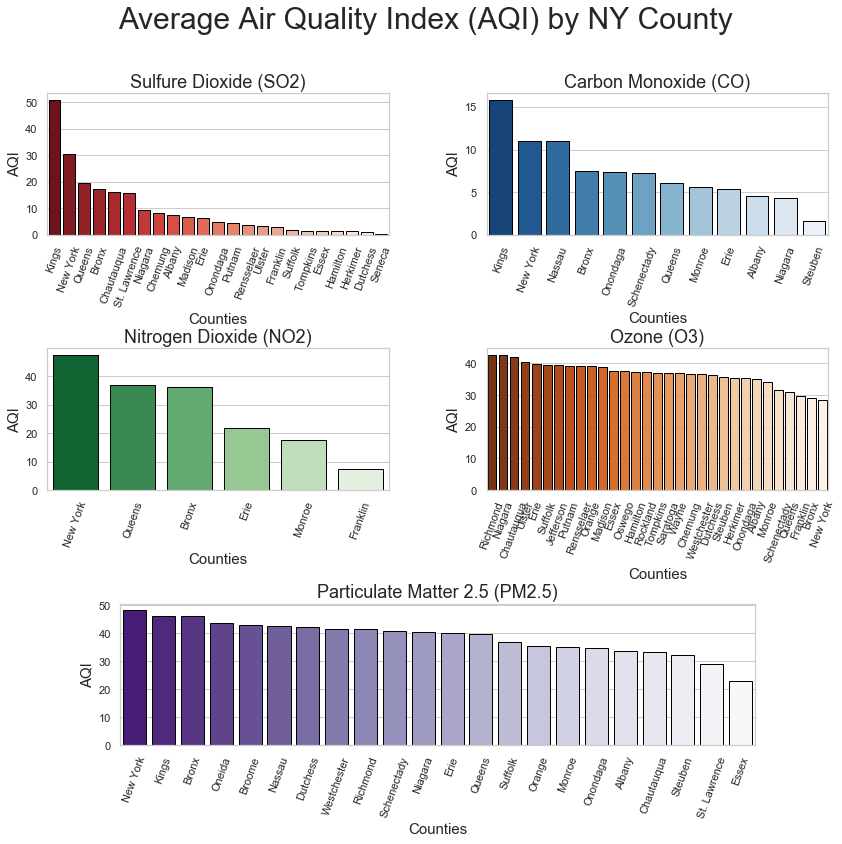

In [24]:
fig, axs = plt.subplots(3,2, figsize=(14, 12),squeeze=False)
fig.suptitle('Average Air Quality Index (AQI) by NY County',fontsize=30)
sns.set(style="whitegrid")
gs = gridspec.GridSpec(11,11)

ax1 = plt.subplot(gs[0:3, 0:5])
ax1.set_title('Sulfure Dioxide (SO2)', fontsize=18)
sns.barplot(x='county_name',y='avg_aqi', data=bar4, ax=ax1, palette="Reds_r",edgecolor='black')
ax1.set_ylabel('AQI', fontsize=15)
ax1.set_xlabel('Counties', fontsize=15)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=70)

ax2 = plt.subplot(gs[0:3, 6:])
ax2.set_title('Carbon Monoxide (CO)', fontsize=18)
sns.barplot(x='county_name',y='avg_aqi', data=bar2, ax=ax2,palette="Blues_r",edgecolor='black')
ax2.set_ylabel('AQI', fontsize=15)
ax2.set_xlabel('Counties', fontsize=15)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=70)

ax3 = plt.subplot(gs[4:7, 0:5])
ax3.set_title('Nitrogen Dioxide (NO2)', fontsize=18)
sns.barplot(x='county_name',y='avg_aqi', data=bar1, ax=ax3,palette="Greens_r",edgecolor='black')
ax3.set_ylabel('AQI', fontsize=15)
ax3.set_xlabel('Counties', fontsize=15)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=70)

ax4 = plt.subplot(gs[4:7, 6:])
ax4.set_title('Ozone (O3)', fontsize=18)
sns.barplot(x='county_name',y='avg_aqi', data=bar5, ax=ax4,palette="Oranges_r",edgecolor='black')
ax4.set_ylabel('AQI', fontsize=15)
ax4.set_xlabel('Counties', fontsize=15)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=70)

ax5 = plt.subplot(gs[8:, 1:10])
ax5.set_title('Particulate Matter 2.5 (PM2.5)', fontsize=18)
sns.barplot(x='county_name',y='avg_aqi', data=bar3, ax=ax5,palette="Purples_r",edgecolor='black')
ax5.set_ylabel('AQI', fontsize=15)
ax5.set_xlabel('Counties', fontsize=15)
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=70)

plt.subplots_adjust(wspace=0.5, hspace=3.5)
plt.show()